In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

In [ ]:
# Read data and get statistics

data = pd.read_csv("wine.csv")
data

In [ ]:
# Check missing data

count = data.count()
assert(len(set(count)) == 1)
count

In [4]:
# Normalize

attributes = data.drop("class", axis=1) # drop `mark` column
[mins, maxs] = attributes.describe().loc[['min', 'max']].values

def normalize(v):
    return [((v[i] - mins[i]) / (maxs[i] - mins[i])) for i in range(len(v))]
    
values = [normalize(v) for v in attributes.values]
pd.DataFrame(values)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.705263,0.970356,0.582888,0.510309,0.271739,0.241379,0.056962,0.735849,0.205047,0.547782,0.130081,0.172161,0.329529
174,0.623684,0.626482,0.598930,0.639175,0.347826,0.282759,0.086498,0.566038,0.315457,0.513652,0.178862,0.106227,0.336662
175,0.589474,0.699605,0.481283,0.484536,0.543478,0.210345,0.073840,0.566038,0.296530,0.761092,0.089431,0.106227,0.397290
176,0.563158,0.365613,0.540107,0.484536,0.543478,0.231034,0.071730,0.754717,0.331230,0.684300,0.097561,0.128205,0.400856


In [5]:
# Append classes to attributes

classes = data["class"].values
d_train = [(values[i], classes[i]) for i in range(len(classes))]
classes = list(set(classes))

In [6]:
# Class functions

def class_by_index(i):
    return classes[i]


def index_by_class(c):
    return classes.index(c)


def empty_class_vector():
    return [0 for i in range(len(classes))]

In [7]:
# KNN (C from CF)


def distance_helper(x, y, fold, inner):
    return fold(map(lambda ab: inner(ab[0] - ab[1]), zip(x, y)))


distances = {
    'manhattan': (lambda x, y: distance_helper(x, y, sum, abs)),
    'euclidean': (lambda x, y: sqrt(distance_helper(x, y, sum, lambda u: u ** 2))),
    'chebyshev': (lambda x, y: distance_helper(x, y, max, abs)),
}

kernels = {
    'uniform':      (lambda u: 0.5),
    'triangular':   (lambda u: 1 - abs(u)),
    'epanechnikov': (lambda u: 0.75 * (1 - u ** 2)),
    'quartic':      (lambda u: (15 / 16) * (1 - u ** 2) ** 2),
}

def simple_goal(objects):
    l = [o[1] for o in objects]
    return max(set(l), key = l.count) 


def knn(objects, target, distance, kernel, window, window_value):
    k = kernels[kernel]
    d = distances[distance]

    objects.sort(key=lambda x: d(x[0], target))
    if window == "fixed":
        h = window_value
    else:
        h = d(objects[window_value][0], target)
        
    assert(h != 0)
    
    def w(x):
        t = d(x, target) / h
        return k(t) if t < 1 else 0

    res = empty_class_vector()
    for a, c in objects:
        res[index_by_class(c)] += w(a)

    max_class = max(res)
    return class_by_index(res.index(max_class)) if max_class != 0 else simple_goal(objects)

In [8]:
# Params

def R(d, D):
    d = distances[d]
    l = list()
    for o1 in D:
        for o2 in D:
            l.append(d(o1[0], o2[0]))
    return max(l)
        
def get_params():
    SD = sqrt(len(d_train))
    
    ans = list()
    for k in kernels:
        for d in distances:
            temp = R(d, d_train) / SD
            for h in range(1, int(SD) + 1):
                ans.append((d, k, "variable", h))
                ans.append((d, k, "fixed", h * temp))
    return ans

In [9]:
# Confusion matrix

def get_cm(d, k, w_t, h):
    cm = [empty_class_vector() for i in range(len(classes))]
    for i in range(len(d_train)):
        copy = d_train.copy()
        (attrs, actual) = copy.pop(i)
        suggestion = knn(copy, attrs, d, k, w_t, h)
        cm[index_by_class(actual)][index_by_class(suggestion)] += 1
    return cm

In [10]:
# F score

def safe_div(a, b):
    return a / b if b else 0


def harmonic(a, b):
    return safe_div(2 * a * b, a + b)

def f_score(CM):
    K = len(classes)
    R = range(K)

    C = [sum(CM[i]) for i in R]
    ALL = sum(C)

    TP = [CM[i][i] for i in R]
    FP = [sum([CM[j][i] for j in R if i != j]) for i in R]
    FN = [sum([CM[i][j] for j in R if i != j]) for i in R]
    TN = [ALL - TP[i] - FP[i] - FN[i] for i in R]

    P = [TP[i] + FP[i] for i in R]

    prec = [safe_div(TP[i], P[i]) for i in R]
    recall = [safe_div(TP[i], TP[i] + FN[i]) for i in R]
    F = [harmonic(prec[i], recall[i]) for i in R]
    microf = sum([C[i] * F[i] for i in R]) / ALL

    precw = sum([safe_div(TP[i] * C[i], P[i]) for i in R]) / ALL
    recallw = sum([TP[i] for i in R]) / ALL
    macrof = harmonic(precw, recallw)
    
    return macrof

In [11]:
# Get stats

stats = list()
for d, k, w_t, h in get_params():
    cm = get_cm(d, k, w_t, h)
    f = f_score(cm)
    stats.append([d, k, w_t, h, f])

In [12]:
pd.DataFrame(stats, columns=["distance", "kernel", "window_type", "h", "f_score"])

,distance,kernel,window_type,h,f_score
0,manhattan,uniform,variable,1.000000,0.961882
1,manhattan,uniform,fixed,0.470877,0.227472
2,manhattan,uniform,variable,2.000000,0.962285
3,manhattan,uniform,fixed,0.941754,0.797303
4,manhattan,uniform,variable,3.000000,0.967229
...,...,...,...,...,...
307,chebyshev,quartic,fixed,0.824485,0.916255
308,chebyshev,quartic,variable,12.000000,0.956060
309,chebyshev,quartic,fixed,0.899438,0.895029
310,chebyshev,quartic,variable,13.000000,0.956060


In [13]:
# Find best

best = max(stats, key=lambda x: x[-1])
best

['manhattan', 'uniform', 'variable', 11, 0.9834175280214206]

In [14]:
# For plots

f_score_with = {
    "fixed": ([], []),
    "variable": ([], [])
}
for s in stats:
    if s[0] != best[0] or s[1] != best[1]:
        continue
    f_score_with[s[2]][0].append(s[3])
    f_score_with[s[2]][1].append(s[4])

Text(0.5, 1.0, 'With variable')

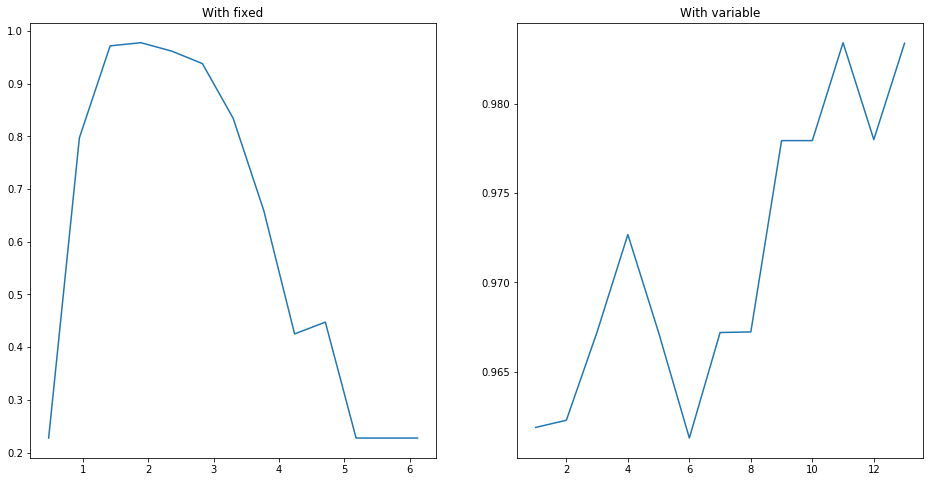

In [15]:
# Plots

_, (x1, x2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

x1.plot(f_score_with["fixed"][0], f_score_with["fixed"][1])
x1.set_title("With fixed")

x2.plot(f_score_with["variable"][0], f_score_with["variable"][1])
x2.set_title("With variable")